In [7]:
from arctic import Arctic
from arctic.date import DateRange
from arctic.exceptions import NoDataFoundException
from arctic.date import DateRange
import pandas as pd
import numpy as np
from ib_insync import IB, ContFuture, util, Future, Forex, Contract
from typing import Union
import pickle
from datetime import datetime, timedelta
import sys
sys.path.append('/home/tomek/ib_tools')
from datastore import ArcticStore
from utils import plot
from indicators import get_signals

In [2]:
conn = Arctic('localhost')
conn.list_libraries()

['history',
 'MIDPOINT_30_secs',
 'test',
 'TRADES_30_secs',
 'TRADES_1_min',
 'TRADES_1_day',
 'test_log',
 'ver_test',
 'TRADES_1 min',
 'TRADES_30_sec']

In [3]:
log = conn['test_log']

In [4]:
log.list_symbols()

['all_bars_20200715_15_51_ESU0',
 'all_bars_20200715_15_51_GCQ0',
 'all_bars_20200715_15_51_NQU0',
 'all_bars_20200715_15_51_YM   SEP 20',
 'candles_20200715_15_51_ESU0',
 'candles_20200715_15_51_GCQ0',
 'candles_20200715_15_51_NQU0',
 'candles_20200715_15_51_YM   SEP 20']

In [26]:
df = log.read('candles_20200715_15_51_ESU0').data
#df.drop(['backfill', 'open', 'high', 'low', 'ema_fast', 'ema_slow'], axis=1, inplace=True)

In [27]:
df.tail(20)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal
date,,,,,,,,,,,,,
2020-07-17 08:57:30,False,3205.50,3208.25,3200.00,3202.75,3202.75,43082,3193.758443,3169.724565,10.027262,0.0,1.0,0.0
2020-07-17 11:14:30,False,3202.75,3205.25,3195.00,3204.25,3204.25,43185,3193.931860,3169.943210,10.029725,0.0,1.0,0.0
2020-07-17 13:50:00,False,3204.00,3209.50,3202.00,3206.75,3206.75,43112,3194.143734,3170.176280,10.001754,0.0,1.0,0.0
2020-07-17 14:55:30,False,3206.75,3217.75,3206.00,3212.50,3212.50,43013,3194.447148,3170.444257,10.021084,0.0,1.0,0.0
2020-07-17 15:30:30,False,3212.50,3219.25,3211.00,3214.75,3214.75,45185,3194.782737,3170.724754,10.001502,0.0,1.0,0.0
2020-07-17 15:39:00,False,3214.50,3216.25,3211.50,3212.50,3212.50,44930,3195.075589,3170.989205,9.943438,0.0,1.0,0.0
2020-07-17 15:47:30,False,3212.50,3213.50,3208.75,3208.75,3208.75,43338,3195.301616,3171.228219,9.886016,0.0,1.0,0.0
2020-07-17 16:00:00,False,3208.50,3214.75,3208.50,3211.00,3211.00,43749,3195.561097,3171.479937,9.845815,0.0,1.0,0.0
2020-07-17 16:11:00,False,3211.00,3213.75,3206.25,3210.00,3210.00,43462,3195.799761,3171.723709,9.819878,0.0,1.0,0.0


In [42]:
df['test'] = get_signals(df['price'], [5,10,20,40,80,160,320,640, 1280, 1280*2])

In [44]:
for i in range(10, 200):
    df['t'] = get_signals(df['price'], [i])
    print(f"{i}: {len(df[df['test'] != df['t']])}")

10: 180
11: 171
12: 164
13: 158
14: 150
15: 143
16: 138
17: 135
18: 129
19: 122
20: 119
21: 115
22: 110
23: 110
24: 108
25: 104
26: 103
27: 101
28: 98
29: 97
30: 95
31: 93
32: 91
33: 90
34: 90
35: 88
36: 87
37: 85
38: 84
39: 82
40: 81
41: 80
42: 78
43: 77
44: 75
45: 73
46: 71
47: 70
48: 67
49: 66
50: 64
51: 63
52: 59
53: 57
54: 54
55: 53
56: 50
57: 47
58: 45
59: 43
60: 41
61: 38
62: 36
63: 33
64: 33
65: 33
66: 33
67: 32
68: 31
69: 30
70: 30
71: 28
72: 27
73: 26
74: 24
75: 23
76: 22
77: 20
78: 19
79: 18
80: 17
81: 17
82: 17
83: 17
84: 17
85: 16
86: 15
87: 15
88: 15
89: 15
90: 15
91: 13
92: 13
93: 12
94: 11
95: 11
96: 11
97: 11
98: 10
99: 10
100: 10
101: 10
102: 10
103: 10
104: 10
105: 10
106: 10
107: 10
108: 10
109: 9
110: 8
111: 7
112: 7
113: 6
114: 6
115: 5
116: 5
117: 4
118: 4
119: 4
120: 4
121: 4
122: 4
123: 4
124: 4
125: 4
126: 4
127: 4
128: 4
129: 4
130: 4
131: 4
132: 4
133: 3
134: 2
135: 2
136: 2
137: 2
138: 2
139: 2
140: 2
141: 2
142: 2
143: 2
144: 2
145: 2
146: 2
147: 2
148: 2


In [23]:
df['cum_s'] = df['signal'].shift()
df

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,s,cum_s
date,,,,,,,,,,,,,,,
2020-06-23 03:10:00,True,3111.75,3125.25,3105.50,3105.75,3105.75,45102,NaN,NaN,19.750000,0.0,NaN,0.0,0.0,0.0
2020-06-23 03:24:00,True,3105.75,3107.50,3070.00,3070.25,3070.25,43409,NaN,NaN,28.674306,0.0,NaN,0.0,0.0,0.0
2020-06-23 03:42:30,True,3070.50,3082.50,3060.00,3066.75,3066.75,43140,NaN,NaN,26.593294,0.0,NaN,0.0,0.0,0.0
2020-06-23 03:59:30,True,3066.75,3110.75,3063.25,3110.50,3110.50,43303,NaN,NaN,31.907402,0.0,NaN,0.0,0.0,0.0
2020-06-23 04:25:30,True,3110.25,3117.75,3099.00,3114.75,3114.75,43448,NaN,NaN,29.217122,0.0,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-17 18:27:30,False,3214.00,3216.25,3212.00,3215.25,3215.25,43213,3197.270597,3173.345926,9.622302,1.0,1.0,1.0,1.0,44.0
2020-07-17 19:04:00,False,3215.00,3215.25,3210.25,3211.75,3211.75,44397,3197.509929,3173.588778,9.571198,0.0,1.0,0.0,1.0,44.0
2020-07-17 19:18:00,True,3211.50,3214.25,3208.25,3209.00,3209.00,43003,3197.699850,3173.812684,9.531716,0.0,1.0,0.0,1.0,44.0


In [15]:
df.tail(20)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,s
date,,,,,,,,,,,,,,
2020-07-17 08:57:30,False,3205.50,3208.25,3200.00,3202.75,3202.75,43082,3193.758443,3169.724565,10.027262,0.0,1.0,0.0,1.0
2020-07-17 11:14:30,False,3202.75,3205.25,3195.00,3204.25,3204.25,43185,3193.931860,3169.943210,10.029725,0.0,1.0,0.0,1.0
2020-07-17 13:50:00,False,3204.00,3209.50,3202.00,3206.75,3206.75,43112,3194.143734,3170.176280,10.001754,0.0,1.0,0.0,1.0
2020-07-17 14:55:30,False,3206.75,3217.75,3206.00,3212.50,3212.50,43013,3194.447148,3170.444257,10.021084,0.0,1.0,0.0,1.0
2020-07-17 15:30:30,False,3212.50,3219.25,3211.00,3214.75,3214.75,45185,3194.782737,3170.724754,10.001502,0.0,1.0,0.0,1.0
2020-07-17 15:39:00,False,3214.50,3216.25,3211.50,3212.50,3212.50,44930,3195.075589,3170.989205,9.943438,0.0,1.0,0.0,1.0
2020-07-17 15:47:30,False,3212.50,3213.50,3208.75,3208.75,3208.75,43338,3195.301616,3171.228219,9.886016,0.0,1.0,0.0,1.0
2020-07-17 16:00:00,False,3208.50,3214.75,3208.50,3211.00,3211.00,43749,3195.561097,3171.479937,9.845815,0.0,1.0,0.0,1.0
2020-07-17 16:11:00,False,3211.00,3213.75,3206.25,3210.00,3210.00,43462,3195.799761,3171.723709,9.819878,0.0,1.0,0.0,1.0


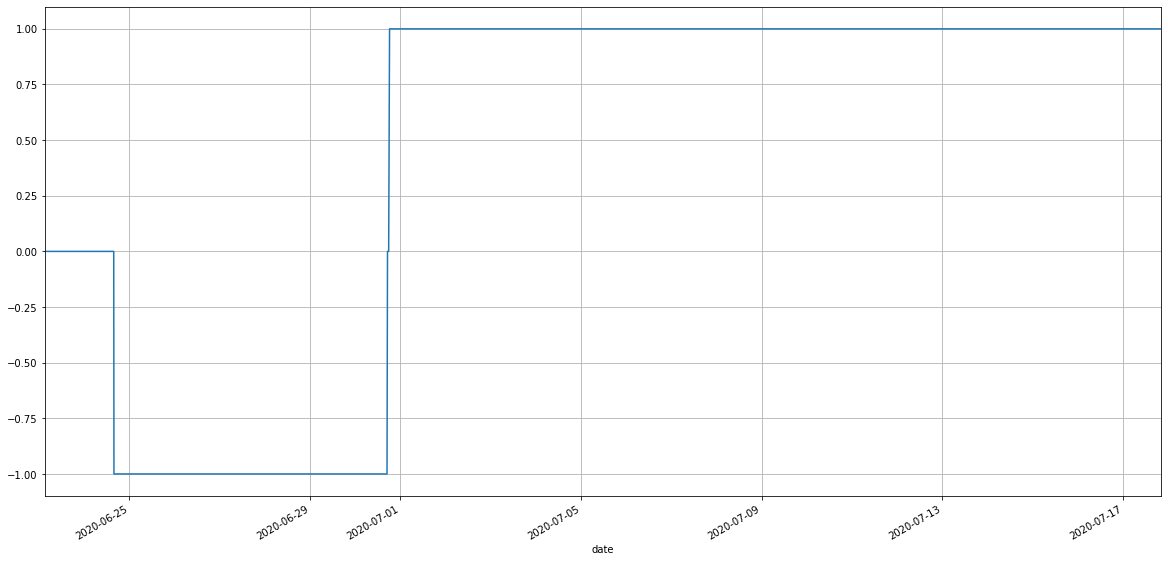

In [16]:
df['s'].plot(figsize=(20,10), grid=True)

In [19]:
df.loc['20200630':].head(50)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,s
date,,,,,,,,,,,,,,
2020-06-30 00:50:30,True,3046.00,3058.00,3044.25,3057.25,3057.25,43035,3029.029164,3040.515598,11.227073,1.0,-1.0,0.0,-1.0
2020-06-30 04:10:30,True,3057.25,3059.25,3046.00,3054.75,3054.75,43023,3029.466450,3040.635587,11.251683,0.0,-1.0,0.0,-1.0
2020-06-30 08:16:00,True,3054.75,3057.00,3036.75,3036.75,3036.75,43202,3029.590221,3040.602905,11.361032,0.0,-1.0,0.0,-1.0
2020-06-30 10:06:00,True,3036.75,3050.00,3035.00,3036.00,3036.00,43270,3029.699093,3040.564274,11.405204,0.0,-1.0,0.0,-1.0
2020-06-30 11:33:00,True,3036.00,3041.75,3030.25,3039.75,3039.75,43501,3029.869733,3040.557455,11.406354,0.0,-1.0,0.0,-1.0
2020-06-30 13:30:30,True,3039.50,3055.25,3036.50,3050.25,3050.25,45053,3030.215585,3040.638452,11.495304,0.0,-1.0,0.0,-1.0
2020-06-30 14:48:00,True,3050.00,3054.50,3035.25,3039.75,3039.75,43154,3030.377312,3040.631044,11.589133,0.0,-1.0,0.0,-1.0
2020-06-30 15:30:00,True,3039.75,3042.50,3035.25,3039.50,3039.50,46233,3030.531989,3040.621632,11.536686,0.0,-1.0,0.0,-1.0
2020-06-30 15:38:00,True,3039.50,3049.75,3037.50,3049.00,3049.00,44834,3030.844983,3040.691206,11.545299,0.0,-1.0,0.0,-1.0


In [6]:
def rsi(price: pd.Series, lookback: int) -> pd.Series:
    df = pd.DataFrame({'price': price})
    df['change'] = df['price'].diff().fillna(0)
    df['up'] = ((df['change'] > 0) * df['change']).rolling(lookback).sum()
    df['down'] = ((df['change'] < 0) * df['change'].abs()).rolling(lookback).sum()
    df['rs'] = df['up'] / df['down']
    df['rsi'] = (100 - (100/(1+df['rs'])))
    return df['rsi']

In [7]:
def modified_rsi(rsi: pd.Series) -> pd.Series:
    return 2*(rsi - 50)

In [8]:
def carver(price: pd.Series, lookback: int) -> pd.Series:
    df = pd.DataFrame({'price': price})
    df['max'] = df['price'].rolling(lookback).max()
    df['min'] = df['price'].rolling(lookback).min()
    df['mid'] = df[['min', 'max']].mean(axis=1)
    df['carver'] = 200*((df['price'] - df['mid']) / (df['max'] - df['min']))
    return df['carver']

In [9]:
df['rsi'] = rsi(df.price, 24)
df['modified_rsi'] = modified_rsi(df['rsi'])
df['carver_rsi'] = carver(df['rsi'], 90).rolling(15).mean()
df

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,rsi,modified_rsi,carver_rsi
date,,,,,,,,,,,,,,,,
2020-06-23 03:10:00,True,3111.75,3125.25,3105.50,3105.75,3105.75,45102,NaN,NaN,19.750000,0.0,NaN,0.0,NaN,NaN,NaN
2020-06-23 03:24:00,True,3105.75,3107.50,3070.00,3070.25,3070.25,43409,NaN,NaN,28.674306,0.0,NaN,0.0,NaN,NaN,NaN
2020-06-23 03:42:30,True,3070.50,3082.50,3060.00,3066.75,3066.75,43140,NaN,NaN,26.593294,0.0,NaN,0.0,NaN,NaN,NaN
2020-06-23 03:59:30,True,3066.75,3110.75,3063.25,3110.50,3110.50,43303,NaN,NaN,31.907402,0.0,NaN,0.0,NaN,NaN,NaN
2020-06-23 04:25:30,True,3110.25,3117.75,3099.00,3114.75,3114.75,43448,NaN,NaN,29.217122,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-17 18:27:30,False,3214.00,3216.25,3212.00,3215.25,3215.25,43213,3197.270597,3173.345926,9.622302,1.0,1.0,1.0,57.000000,14.000000,-14.378095
2020-07-17 19:04:00,False,3215.00,3215.25,3210.25,3211.75,3211.75,44397,3197.509929,3173.588778,9.571198,0.0,1.0,0.0,60.477454,20.954907,-12.205180
2020-07-17 19:18:00,True,3211.50,3214.25,3208.25,3209.00,3209.00,43003,3197.699850,3173.812684,9.531716,0.0,1.0,0.0,55.182073,10.364146,-11.935521


/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


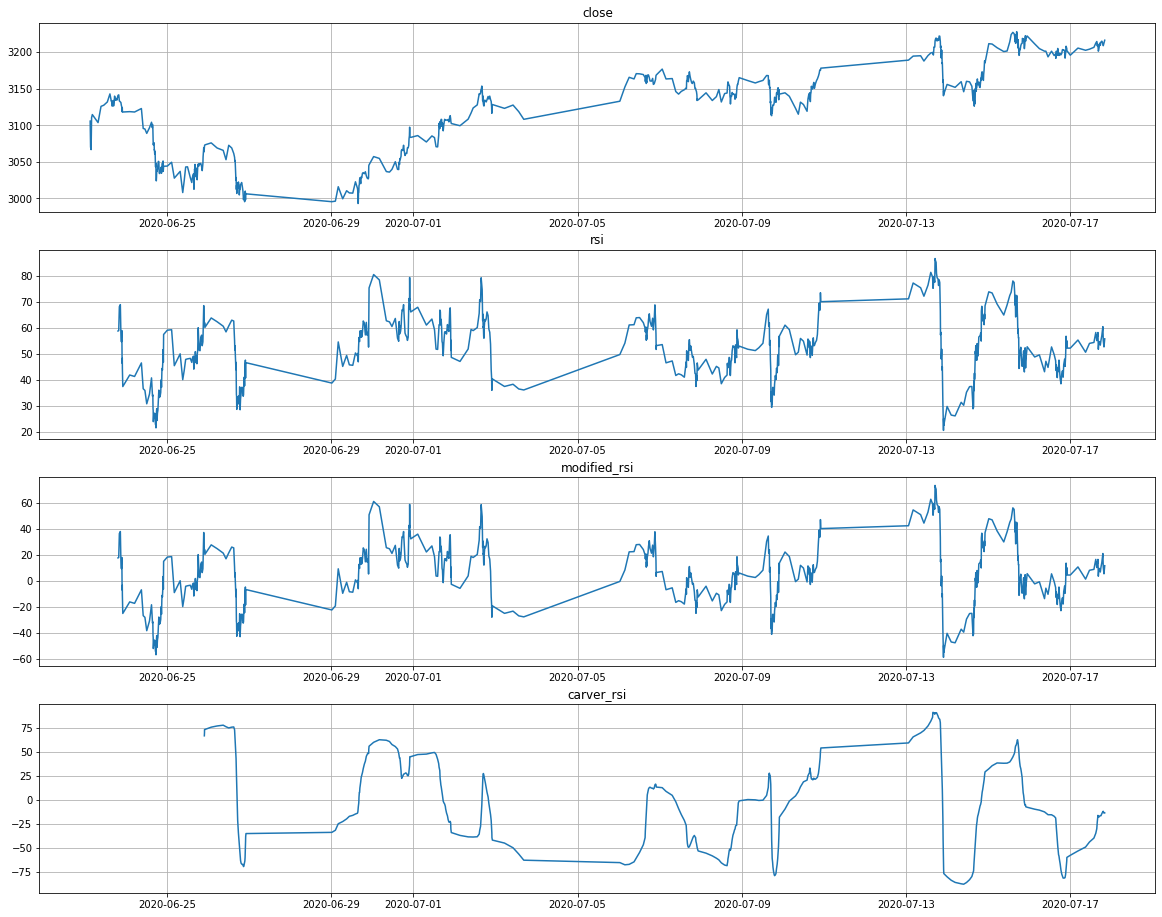

In [10]:
plot(df[['close', 'rsi', 'modified_rsi', 'carver_rsi']]);

In [140]:
def range_crosser(ind:pd.Series, threshold: float) -> pd.Series:
    df = pd.DataFrame({'ind': ind})
    df['inside'] = (df['ind'].abs() < threshold) 
    df['ss'] = ~(df['inside'].shift().fillna(False)) & df['inside']
    df['s'] = np.sign(df['ind'].diff())
    df['signal'] = df['ss'] * df['s']
    return df['signal']

In [141]:
df['s'] = range_crosser(df['carver_rsi'], 50)

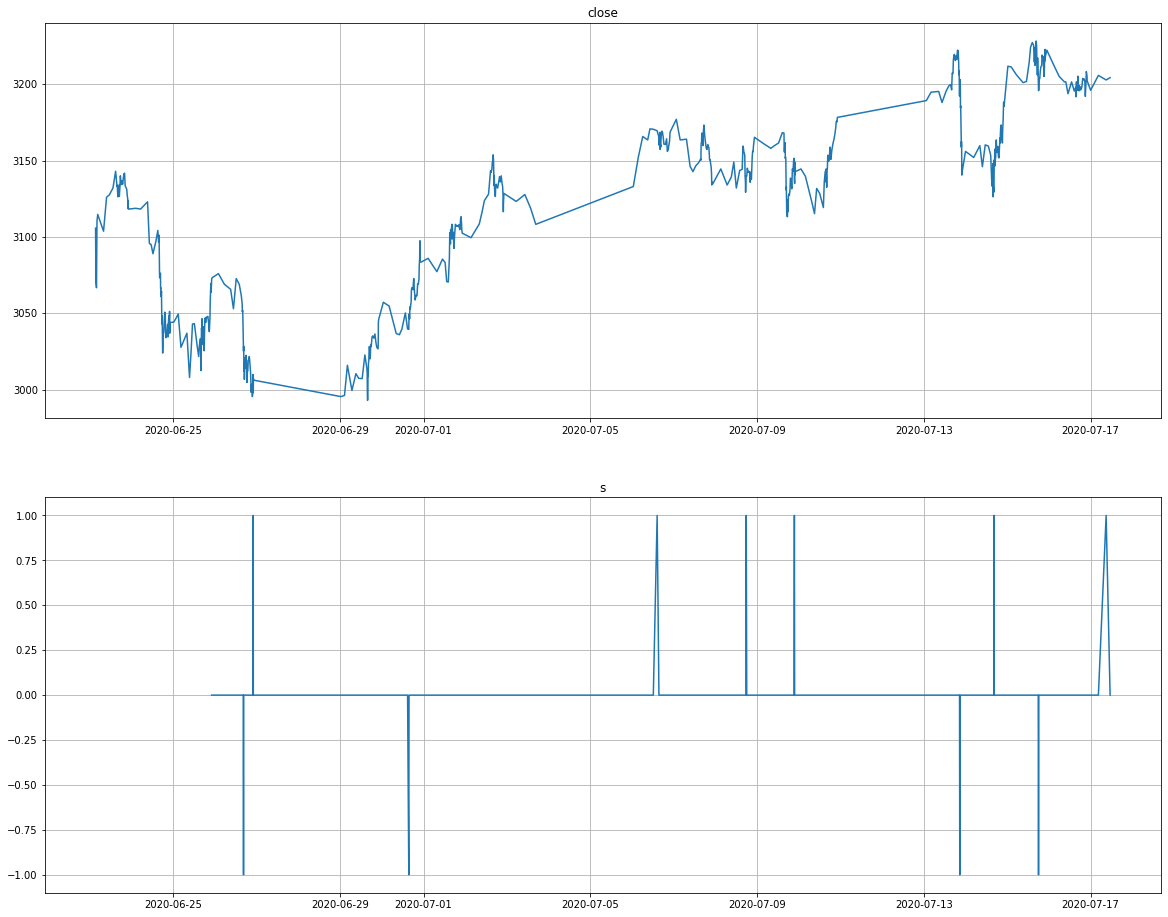

In [142]:
plot(df[['close', 's']]);

In [133]:
df.loc['20200713':].head(50)

,backfill,open,high,low,close,price,volume,ema_fast,ema_slow,atr,signal,filter,filtered_signal,rsi,modified_rsi,carver_rsi,s
date,,,,,,,,,,,,,,,,,
2020-07-13 00:00:30,True,10820.75,10876.00,10817.50,10858.75,10858.75,12049,10822.689734,10675.046703,32.362444,1.0,1.0,1.0,86.533449,73.066898,37.956302,0.0
2020-07-13 02:01:30,True,10859.50,10909.50,10850.75,10873.50,10873.50,12019,10839.626489,10678.327506,32.654945,1.0,1.0,1.0,84.668645,69.337290,43.219446,0.0
2020-07-13 03:48:30,True,10874.50,10899.75,10858.25,10891.00,10891.00,12036,10856.750993,10681.843370,32.752988,1.0,1.0,1.0,89.124158,78.248316,50.510710,0.0
2020-07-13 07:11:00,True,10891.75,10897.25,10871.00,10888.00,10888.00,12022,10867.167328,10685.251504,32.680908,0.0,1.0,0.0,86.673774,73.347548,57.312097,0.0
2020-07-13 09:05:30,True,10888.00,10917.00,10885.25,10890.75,10890.75,12002,10875.028219,10688.648749,32.670590,0.0,1.0,0.0,87.288136,74.576271,65.995620,0.0
2020-07-13 10:12:00,True,10890.75,10899.25,10878.75,10889.50,10889.50,12104,10879.852146,10691.969157,32.535700,0.0,1.0,0.0,86.828240,73.656481,70.918259,0.0
2020-07-13 11:37:00,True,10889.00,10894.50,10866.00,10890.50,10890.50,12055,10883.401431,10695.251197,32.490973,0.0,1.0,0.0,88.556150,77.112299,77.177062,0.0
2020-07-13 13:07:00,True,10890.75,10934.00,10884.50,10933.00,10933.00,12095,10899.934287,10699.181562,32.679476,1.0,1.0,1.0,90.192484,80.384968,84.069491,0.0
2020-07-13 14:19:30,True,10933.25,10951.75,10924.25,10930.50,10930.50,12125,10910.122858,10703.005613,32.622076,0.0,1.0,0.0,88.695652,77.391304,91.013033,0.0


In [ ]:
df['rsi_filtered_signal'] = df['rsi_signal'] * ((df['rsi_signal'] * df['filter']) == 1)
    df['p'] = (df['price'] - df['ema_slow']) 

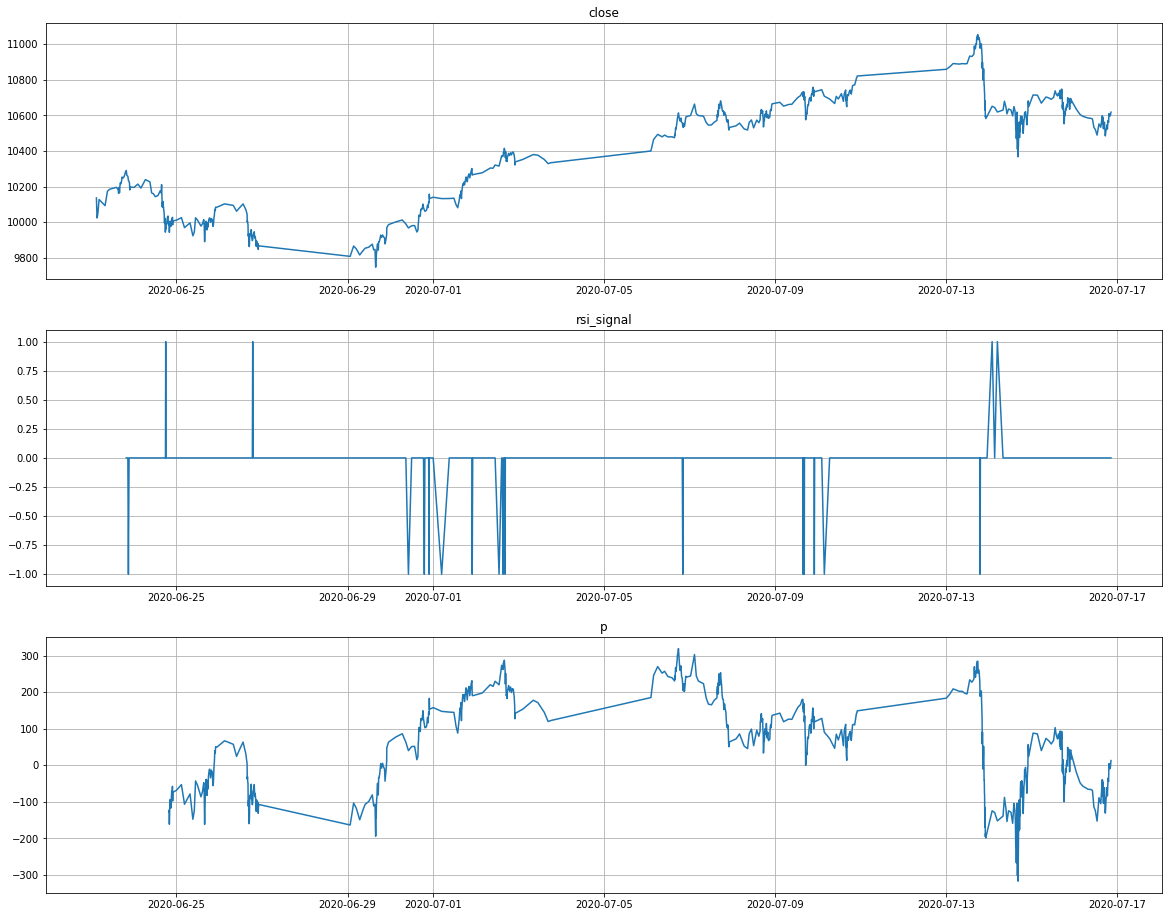

In [59]:
plot(df[['close', 'rsi_signal', 'p']]);

In [49]:
df['rsi'].min(), df['rsi'].max()

(-62.3121387283237, 91.85441941074524)

In [50]:
df[df['rsi_filtered_signal'] != 0].dropna()

,close,price,volume,atr,signal,filter,filtered_signal,change,up,down,rs,rsi,rsi_inside,ss,s,rsi_signal,rsi_filtered_signal
date,,,,,,,,,,,,,,,,,


In [51]:
df[df['rsi_signal'] != 0].dropna()

,close,price,volume,atr,signal,filter,filtered_signal,change,up,down,rs,rsi,rsi_inside,ss,s,rsi_signal,rsi_filtered_signal
date,,,,,,,,,,,,,,,,,
2020-06-26 18:48:30,9901.75,9901.75,12322,39.111377,0.0,-1.0,0.0,5.50,130.00,298.50,0.435511,-39.323221,True,True,1.0,1.0,0.0
2020-06-30 10:10:30,9967.50,9967.50,12028,38.192829,0.0,1.0,0.0,-22.50,272.75,142.75,1.910683,31.287605,True,True,-1.0,-1.0,-0.0
2020-06-30 19:05:30,10069.00,10069.00,12118,36.165110,0.0,1.0,0.0,-12.00,223.75,124.25,1.800805,28.591954,True,True,-1.0,-1.0,-0.0
2020-06-30 21:48:00,10109.75,10109.75,12119,35.417609,0.0,1.0,0.0,-4.50,233.50,104.75,2.229117,38.063562,True,True,-1.0,-1.0,-0.0
2020-07-01 04:49:00,10132.25,10132.25,12011,35.307094,0.0,1.0,0.0,-7.75,234.75,100.75,2.330025,39.940387,True,True,-1.0,-1.0,-0.0
2020-07-01 21:58:30,10264.50,10264.50,12909,34.645386,0.0,1.0,0.0,-36.75,268.75,158.75,1.692913,25.730994,True,True,-1.0,-1.0,-0.0
2020-07-02 13:02:00,10315.00,10315.00,12106,34.294435,0.0,1.0,0.0,-6.00,266.00,114.50,2.323144,39.816032,True,True,-1.0,-1.0,-0.0
2020-07-02 15:17:00,10370.25,10370.25,12027,34.243921,0.0,1.0,0.0,2.25,274.50,119.50,2.297071,39.340102,True,True,-1.0,-1.0,-0.0
2020-07-02 16:26:00,10394.75,10394.75,12548,33.756115,0.0,1.0,0.0,-10.50,267.25,126.00,2.121032,35.918627,True,True,-1.0,-1.0,-0.0


In [ ]:
df.loc['2020-06-25 07:00:00':].head(10)

In [ ]:
df['mean'] = df['price'].rolling(90).mean()
df['std'] = df['price'].rolling(90).std()
df['diff'] = df['price'] - df['mean']
df['mul'] = df['diff']/df['std']
df['rsi_std_filtered_signal'] = df['rsi_signal'] * ((df['signal'] * df['filter']) == 1)
df

In [ ]:
plot(df[['close', 'mul', 'rsi_signal']]);